In [1]:
import networkx as nx

In [5]:
# Working with karate club datset
G = nx.karate_club_graph()
print("Number of nodes (club members)", len(G.nodes))

Number of nodes (club members) 34


In [6]:
# Plot the graph with labels
# There are two labels for this dataset
# 1. officer 2. Mr.Hi
labels = []
for n in G.nodes:
    club_name = G.nodes[n]['club']
    labels.append(1 if club_name == "Officer" else 0)

In [8]:
import numpy as np

In [9]:
# Node2Vec is almost similar to DeepWalk 
# Only difference is Node2Vec has biased random walk

def biased_random_walk(graph, node, walk_length, p, q):
    walk = [node]

    for _ in range(walk_length-1):
        neighbors = list(graph.neighbors(walk[-1]))


        if len(neighbors) == 0:
            break

        if np.random.uniform(0, 1) < p:  # Exploration
            random_node = np.random.choice(neighbors)
        elif np.random.uniform(0, 1) < p + q: # Exploitation
            random_node = walk[-1]
        
        walk.append(random_node)
    return walk

In [13]:
def generate_all_walks(graph, num_walks, walk_length, p, q):
    walks = []
    nodes = list(graph.nodes())
    for _ in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(biased_random_walk(graph, node, walk_length, p, q))
    return walks

In [24]:
walks = generate_all_walks(G, num_walks=10, walk_length=20, p=0.5, q=0.5)

In [25]:
from gensim.models import Word2Vec

In [26]:
#Learning embeding with Word2Vec model
# In order to learn embeddings we need to convert the walks in list of strings

def learn_embeddings(walks, dimensions, window_size, workers=4):
    walks = [[str(node) for node in walk] for walk in walks]
    model = Word2Vec(walks, vector_size=dimensions, window=window_size, min_count=0, sg=1, workers=workers)
    return model

In [27]:
model = learn_embeddings(walks, dimensions=64, window_size=5)
# Extracting embeddings from the model
embeddings = np.array([model.wv[str(node)] for node in G.nodes()])

In [28]:
# Visualizing the embeddings in low dim
import sklearn
from sklearn import decomposition
import matplotlib.pyplot as plt

pca_model = decomposition.PCA(2)
low_dim_embed = pca_model.fit_transform(embeddings)
print("low dim in shape", low_dim_embed.shape)

low dim in shape (34, 2)


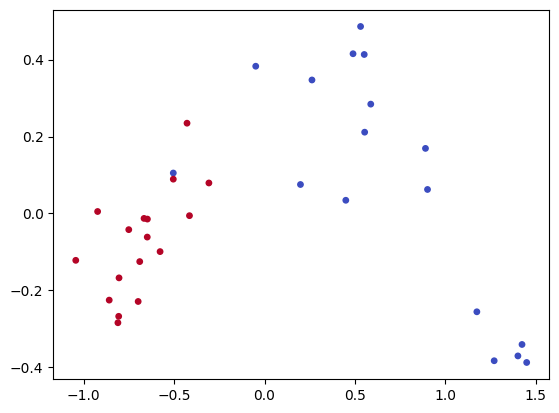

In [29]:
plt.scatter(low_dim_embed[:, 0], low_dim_embed[:, 1], c=labels, 
            s=15, cmap="coolwarm")

In [30]:
# Next we will do the node classification with logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [31]:
x_train, x_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3)
clf_model = LogisticRegression(random_state=0).fit(x_train, y_train)
y_predict = clf_model.predict(x_test)

auc = roc_auc_score(y_test, y_predict)
print("AUC", auc)

AUC 1.0


In [32]:
# Using high level API's from torch_geometric to test Node2Vec


In [36]:
import torch
from torch_geometric.nn import Node2Vec

In [34]:
# Cora data prep from torch_geometric
from torch_geometric.datasets import Planetoid

In [35]:
dataset = Planetoid("./", "Cora")
data = dataset[0]
print("Cora", data)

Cora Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


In [44]:
# Node2Vec in torch
device = "cpu" # Currently pytorch_geometric dont support "mps"
Node2Vec_model = Node2Vec(data.edge_index,
                          embedding_dim=64,
                          walk_length=20,
                          context_size=10,
                          walks_per_node=10,
                          num_negative_samples=1,
                          p=1,
                          q=1,
                          sparse=True).to(device)

loader = Node2Vec_model.loader(batch_size=128,
                               shuffle=True,
                               num_workers=4)

In [45]:
# Training
optimizer = torch.optim.SparseAdam(list(Node2Vec_model.parameters()),
                                   lr=0.01)
def train():
    Node2Vec_model.train()
    total_loss = 0


    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = Node2Vec_model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')


Epoch: 1, Loss: 5.5305
Epoch: 2, Loss: 4.0377
Epoch: 3, Loss: 3.1661
Epoch: 4, Loss: 2.5984
Epoch: 5, Loss: 2.1866
Epoch: 6, Loss: 1.8755
Epoch: 7, Loss: 1.6455
Epoch: 8, Loss: 1.4674
Epoch: 9, Loss: 1.3294
Epoch: 10, Loss: 1.2308
Epoch: 11, Loss: 1.1519
Epoch: 12, Loss: 1.0923
Epoch: 13, Loss: 1.0447
Epoch: 14, Loss: 1.0123
Epoch: 15, Loss: 0.9831
Epoch: 16, Loss: 0.9608
Epoch: 17, Loss: 0.9444
Epoch: 18, Loss: 0.9289
Epoch: 19, Loss: 0.9180
Epoch: 20, Loss: 0.9069
Epoch: 21, Loss: 0.8990
Epoch: 22, Loss: 0.8915
Epoch: 23, Loss: 0.8844
Epoch: 24, Loss: 0.8801
Epoch: 25, Loss: 0.8743
Epoch: 26, Loss: 0.8709
Epoch: 27, Loss: 0.8661
Epoch: 28, Loss: 0.8648
Epoch: 29, Loss: 0.8612
Epoch: 30, Loss: 0.8564
Epoch: 31, Loss: 0.8556
Epoch: 32, Loss: 0.8531
Epoch: 33, Loss: 0.8519
Epoch: 34, Loss: 0.8500
Epoch: 35, Loss: 0.8488
Epoch: 36, Loss: 0.8480
Epoch: 37, Loss: 0.8455
Epoch: 38, Loss: 0.8450
Epoch: 39, Loss: 0.8432
Epoch: 40, Loss: 0.8425
Epoch: 41, Loss: 0.8413
Epoch: 42, Loss: 0.8412
E

In [38]:
from sklearn.manifold import TSNE

In [46]:
# Plotting the data
def plot_points(colors):
    Node2Vec_model.eval()
    with torch.no_grad():
        z = Node2Vec_model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()
    plt.figure()
    for i in range(dataset.num_classes):
        plt.scatter(z[y==i, 0], 
                    z[y==i, 1],
                    s=20,
                    color=colors[i]
                    )
    plt.axis("off")
    plt.show()

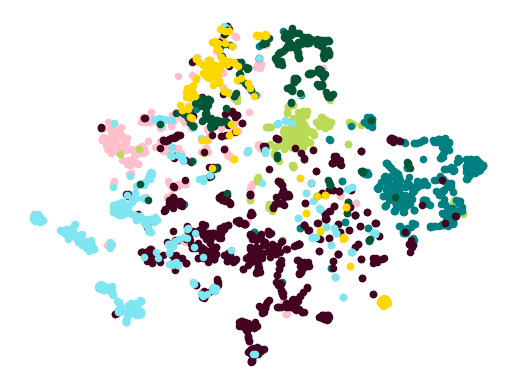

In [47]:
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)

In [49]:
# Node classification
def test():
    Node2Vec_model.eval()
    z = Node2Vec_model()
    acc = Node2Vec_model.test(z[data.train_mask], data.y[data.train_mask],
                              z[data.test_mask], data.y[data.test_mask],
                               max_iter=150)
    return acc

print(f"Accuracy: {test(): .4f}")

Accuracy:  0.7330


In [50]:
torch.save(Node2Vec_model.state_dict(), 'node2vec_model.pth')